# Imports

In [45]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

from keras.utils import to_categorical
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Dropout, Reshape, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

# Parameters

In [46]:
N_EPOCHS = 200
BATCH_SIZE = 16
DATASET_SIZE = 330
TRAIN_DATA_SIZE = int(DATASET_SIZE - (DATASET_SIZE * 0.2))
LATENT_DIM = 128

# Data importing and pre-processing

In [47]:
df = pd.read_csv('dataset.csv', header=None)


df = df.values.reshape(DATASET_SIZE, 64, 64, 1)

x_real_train, x_real_test = train_test_split(df, test_size=0.2)


normalize dataset data into range of sigmoid [0,1], and put into batches

In [48]:
x_real_train = x_real_train.astype('float32')
x_real_train /=255


training_data = tf.data.Dataset.from_tensor_slices(x_real_train).shuffle(TRAIN_DATA_SIZE).batch(BATCH_SIZE)

Visualise example from dataset

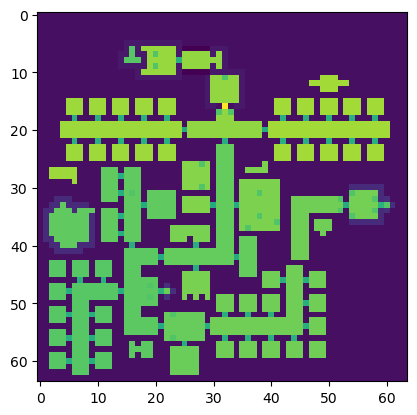

In [49]:
plt.imshow(df[0])

# Generator Model

Create points in latent space to be fed into generator

In [50]:
def generate_generator_input(no_of_maps):
    input = tf.random.normal(shape=(no_of_maps, LATENT_DIM))
    
    return input

In [51]:
def make_generator():
    model = Sequential()
    
    model.add(Dense(LATENT_DIM*8*8, input_shape=(LATENT_DIM,)))

    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8,8,LATENT_DIM)))


    
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(8,8,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(16,16,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    


    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(32,32,60)))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=5, padding="same"))
    model.add(Activation("sigmoid"))
    
              
    model.summary()
    
    return model
    
    

# Discriminator Model

In [52]:

def make_discriminator():
    
    # 1st set of layers
    model = Sequential()
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same", input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    

    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    '''
    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    '''
    
    model.add(Dense(100, activation='relu'))
    #model.add(Activation='relu')
    
    # output layer
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1)) # Binary classification (2 outputs), so only 1 dense layer needed
    model.add(Activation('sigmoid'))
    
    model.summary()
    return model
    

Create the models from the functions

In [53]:
gen_model = make_generator()

disc_model = make_discriminator()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              1056768   
                                                                 
 batch_normalization_8 (Bat  (None, 8192)              32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 16, 16, 128)       262144    
 Transpose)                                                      
                                                                 
 batch_normalization_9 (Bat  (None, 16, 16, 128)      

Next, test the untrained discriminator on the map of noise generated before

Negative values means fake, positive means real

## Loss and Optimizers

In [54]:
cross_entropy = BinaryCrossentropy(from_logits=True)



Discriminator loss, taken from: https://www.tensorflow.org/tutorials/generative/dcgan

In [55]:
def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [56]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [57]:
gen_optimizer = Adam(learning_rate =0.0001, beta_1=0.5)
disc_optimizer = Adam(learning_rate =0.0001, beta_1=0.5)

Discriminator accuracy

In [58]:
def compute_discrim_accuracy(real_output, fake_output):
    if real_output[0] >=0:
        
        if fake_output[0] <0:
            accuracy = (real_output[0] + fake_output[0]) / (real_output[0] + fake_output[0])
        else:
            accuracy = real_output[0]/ (real_output[0] + fake_output[0])
    elif fake_output[0] <0:
        accuracy = fake_output[0] / (real_output[0] + fake_output[0])
    else:
        accuracy = 0/ (real_output[0] + fake_output[0])
    
    return accuracy

## Training

Training step

In [59]:
@tf.function
def training_step(current_batch):
    
    noise_sample = generate_generator_input(BATCH_SIZE)
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_map = gen_model(noise_sample, training=True)
        print("generated map shape" + str(generated_map.shape))
        
        fake_output = disc_model(generated_map,  training=True)
        real_output = disc_model(current_batch, training=True)
        

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discrim_loss(real_output=real_output, fake_output=fake_output)

        disc_accuracy = compute_discrim_accuracy(real_output, fake_output)

        

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return gen_loss, disc_loss, disc_accuracy

Train models

In [60]:
def train(dataset, N_EPOCHS):

    gen_losses = []
    disc_losses = []

    disc_accuracies = []
    
    img_seed = generate_generator_input(1)

    for epoch in range(N_EPOCHS):
        gen_losses_for_epoch = []
        disc_losses_for_epoch = []

        disc_accuracies_for_epoch = []

        print("epoch = " + str(epoch))

        for map_batch in dataset:
            
            
            gen_loss, disc_loss, disc_accuracy = training_step(map_batch)

            gen_losses_for_epoch.append(gen_loss)
            disc_losses_for_epoch.append(disc_loss)
            disc_accuracies.append(disc_accuracy)
        
        avg_gen_loss = sum(gen_losses_for_epoch) / TRAIN_DATA_SIZE
        avg_disc_loss = sum(disc_losses_for_epoch) / TRAIN_DATA_SIZE

        avg_disc_accuracy = sum(disc_accuracies_for_epoch) / TRAIN_DATA_SIZE

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        disc_accuracies.append(avg_disc_accuracy)

        print("Gen loss = " + str(avg_gen_loss))
        print("Disc loss = " + str(avg_disc_loss))

        print("Disc accuracy = " + str(avg_disc_accuracy))
# generate and show a map after 10 epochs

        if epoch % 10 == 0:
            
            generated_map = gen_model(img_seed, training=False)
            generated_map *= 255
            generated_map = generated_map.numpy()
            generated_map.reshape(64,64)
            generated_map = np.round(generated_map,0)
            generated_map = generated_map.tolist()
            plt.imshow(generated_map[0])
            plt.show()
    
    input_for_map_after_training = generate_generator_input(1)
    generated_map = gen_model(input_for_map_after_training, training=False)

    

    return gen_losses, disc_losses, generated_map, disc_accuracies


Train GAN

epoch = 0
generated map shape(16, 64, 64, 1)


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


generated map shape(16, 64, 64, 1)
generated map shape(16, 64, 64, 1)
Gen loss = tf.Tensor(0.038966425, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09067236, shape=(), dtype=float32)
Disc accuracy = 0.0


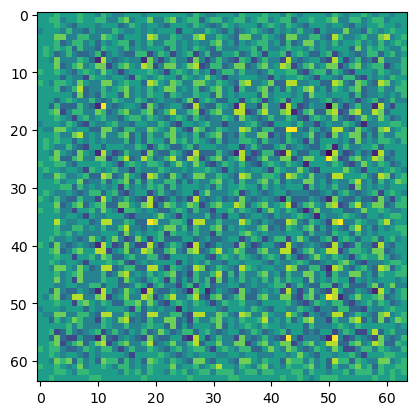

epoch = 1
Gen loss = tf.Tensor(0.050235838, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.072201885, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 2
Gen loss = tf.Tensor(0.043872267, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07932323, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 3
Gen loss = tf.Tensor(0.055500027, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07367707, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 4
Gen loss = tf.Tensor(0.05113373, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0803108, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 5
Gen loss = tf.Tensor(0.056141514, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08293898, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 6
Gen loss = tf.Tensor(0.052227605, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09165956, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 7
Gen loss = tf.Tensor(0.035067305, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11441495, shape=(), 

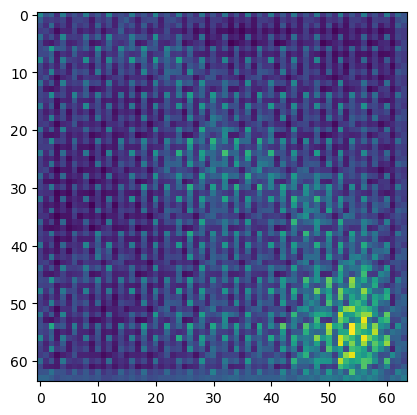

epoch = 11
Gen loss = tf.Tensor(0.049254656, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08283952, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 12
Gen loss = tf.Tensor(0.04874523, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08888643, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 13
Gen loss = tf.Tensor(0.044977088, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09203295, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 14
Gen loss = tf.Tensor(0.04345237, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09701306, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 15
Gen loss = tf.Tensor(0.042850066, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09431467, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 16
Gen loss = tf.Tensor(0.047155328, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08831328, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 17
Gen loss = tf.Tensor(0.045287196, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09064333, shap

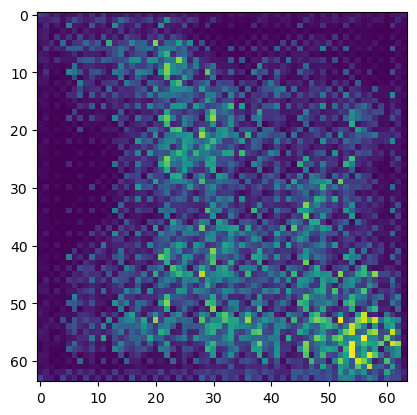

epoch = 21
Gen loss = tf.Tensor(0.044451367, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09609179, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 22
Gen loss = tf.Tensor(0.040855974, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09903585, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 23
Gen loss = tf.Tensor(0.0388744, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.101991296, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 24
Gen loss = tf.Tensor(0.038427707, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.100460194, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 25
Gen loss = tf.Tensor(0.038815714, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10238127, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 26
Gen loss = tf.Tensor(0.03890674, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.100872196, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 27
Gen loss = tf.Tensor(0.037200198, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10325814, sh

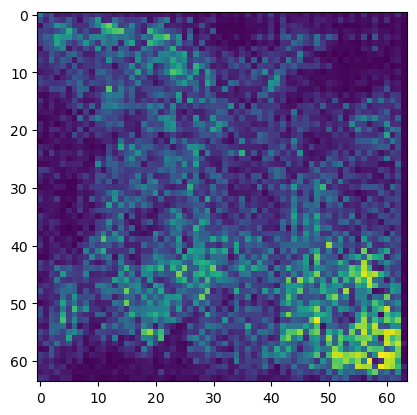

epoch = 31
Gen loss = tf.Tensor(0.03658675, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10488352, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 32
Gen loss = tf.Tensor(0.039124317, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.101631686, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 33
Gen loss = tf.Tensor(0.03871134, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10110553, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 34
Gen loss = tf.Tensor(0.038535018, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10175896, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 35
Gen loss = tf.Tensor(0.040307835, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.098179616, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 36
Gen loss = tf.Tensor(0.04037576, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09894793, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 37
Gen loss = tf.Tensor(0.041119408, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.098757975, sh

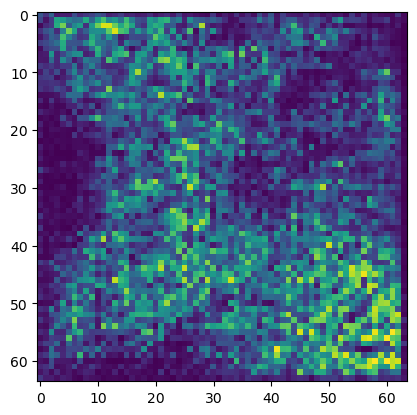

epoch = 41
Gen loss = tf.Tensor(0.040551484, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09810412, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 42
Gen loss = tf.Tensor(0.04040661, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.097864665, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 43
Gen loss = tf.Tensor(0.040883865, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.097539745, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 44
Gen loss = tf.Tensor(0.041457213, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.097057685, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 45
Gen loss = tf.Tensor(0.04194065, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09615652, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 46
Gen loss = tf.Tensor(0.04145232, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.096700594, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 47
Gen loss = tf.Tensor(0.041516755, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0965652, sh

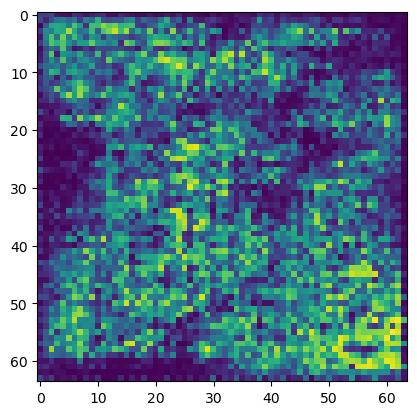

epoch = 51
Gen loss = tf.Tensor(0.042363316, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0949052, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 52
Gen loss = tf.Tensor(0.042637724, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09396686, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 53
Gen loss = tf.Tensor(0.042859536, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09433404, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 54
Gen loss = tf.Tensor(0.043268148, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09359239, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 55
Gen loss = tf.Tensor(0.042642437, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.094139695, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 56
Gen loss = tf.Tensor(0.042996287, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.094251074, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 57
Gen loss = tf.Tensor(0.042737108, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09371952, s

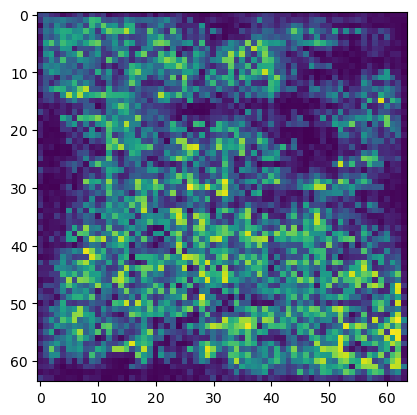

epoch = 61
Gen loss = tf.Tensor(0.043789864, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09263814, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 62
Gen loss = tf.Tensor(0.043115173, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0930818, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 63
Gen loss = tf.Tensor(0.04337807, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09250906, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 64
Gen loss = tf.Tensor(0.04296929, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.092724554, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 65
Gen loss = tf.Tensor(0.044424646, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.092056595, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 66
Gen loss = tf.Tensor(0.043337196, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.092314534, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 67
Gen loss = tf.Tensor(0.043091055, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.091841385, s

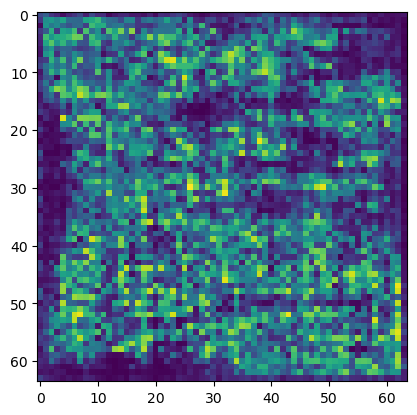

epoch = 71
Gen loss = tf.Tensor(0.04301171, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09225189, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 72
Gen loss = tf.Tensor(0.044152915, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09168255, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 73
Gen loss = tf.Tensor(0.042578712, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09233939, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 74
Gen loss = tf.Tensor(0.043672428, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09124864, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 75
Gen loss = tf.Tensor(0.044142816, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.091517285, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 76
Gen loss = tf.Tensor(0.043744694, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.091854945, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 77
Gen loss = tf.Tensor(0.042736776, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.091427855, 

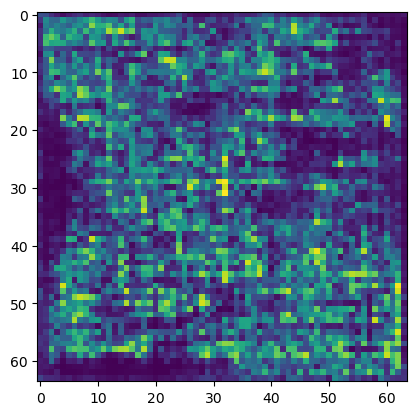

epoch = 81
Gen loss = tf.Tensor(0.043403126, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09101212, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 82
Gen loss = tf.Tensor(0.044024397, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09076999, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 83
Gen loss = tf.Tensor(0.04431643, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09042571, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 84
Gen loss = tf.Tensor(0.043514434, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09075944, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 85
Gen loss = tf.Tensor(0.04372414, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09085715, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 86
Gen loss = tf.Tensor(0.044835586, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08996001, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 87
Gen loss = tf.Tensor(0.042974975, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0906396, shape

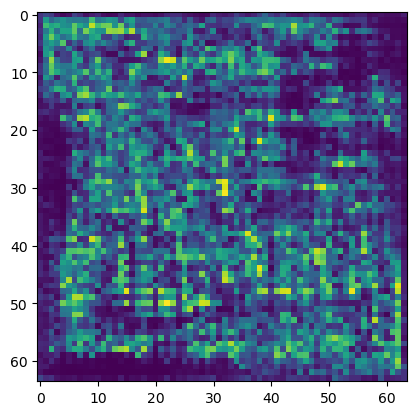

epoch = 91
Gen loss = tf.Tensor(0.04369382, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09028554, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 92
Gen loss = tf.Tensor(0.04357169, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0904537, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 93
Gen loss = tf.Tensor(0.044523552, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08953215, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 94
Gen loss = tf.Tensor(0.044025786, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09001569, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 95
Gen loss = tf.Tensor(0.043947615, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08984953, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 96
Gen loss = tf.Tensor(0.04529293, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.090133116, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 97
Gen loss = tf.Tensor(0.043773253, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09017484, shape

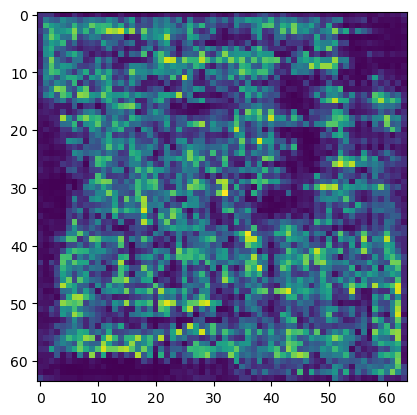

epoch = 101
Gen loss = tf.Tensor(0.044232927, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0892868, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 102
Gen loss = tf.Tensor(0.04495078, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.089620724, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 103
Gen loss = tf.Tensor(0.04656773, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08922135, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 104
Gen loss = tf.Tensor(0.04341677, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08966439, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 105
Gen loss = tf.Tensor(0.044193767, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.089791946, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 106
Gen loss = tf.Tensor(0.046675988, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08908748, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 107
Gen loss = tf.Tensor(0.043632653, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0893407

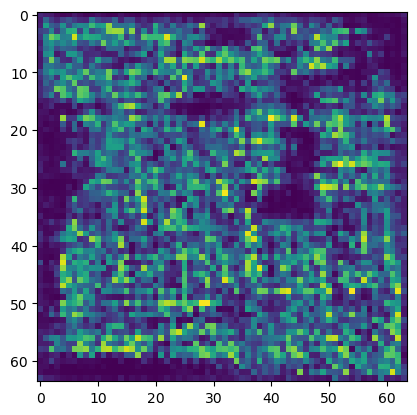

epoch = 111
Gen loss = tf.Tensor(0.04483128, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08885301, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 112
Gen loss = tf.Tensor(0.04503455, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08883672, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 113
Gen loss = tf.Tensor(0.045749605, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08852805, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 114
Gen loss = tf.Tensor(0.045348037, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0881327, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 115
Gen loss = tf.Tensor(0.045793235, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08847658, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 116
Gen loss = tf.Tensor(0.046268262, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08863948, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 117
Gen loss = tf.Tensor(0.04461092, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08778671,

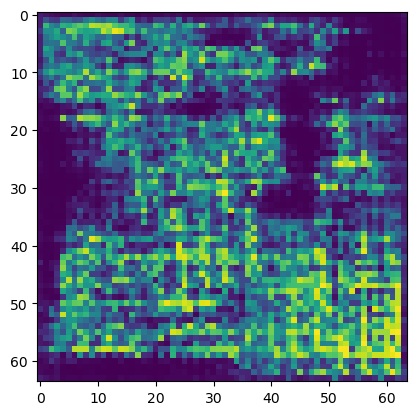

epoch = 121
Gen loss = tf.Tensor(0.047435954, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0877426, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 122
Gen loss = tf.Tensor(0.043374777, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08718199, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 123
Gen loss = tf.Tensor(0.048808992, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08756807, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 124
Gen loss = tf.Tensor(0.04517468, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.087648936, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 125
Gen loss = tf.Tensor(0.045776244, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08765462, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 126
Gen loss = tf.Tensor(0.04767516, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.086858764, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 127
Gen loss = tf.Tensor(0.043851502, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.087049

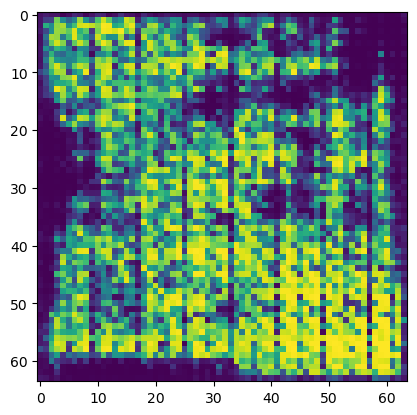

epoch = 131
Gen loss = tf.Tensor(0.051222082, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08473648, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 132
Gen loss = tf.Tensor(0.044937063, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08520223, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 133
Gen loss = tf.Tensor(0.051007766, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.086224064, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 134
Gen loss = tf.Tensor(0.050419, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08235741, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 135
Gen loss = tf.Tensor(0.045994025, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.085463926, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 136
Gen loss = tf.Tensor(0.05380431, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.085953936, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 137
Gen loss = tf.Tensor(0.046647996, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.085004

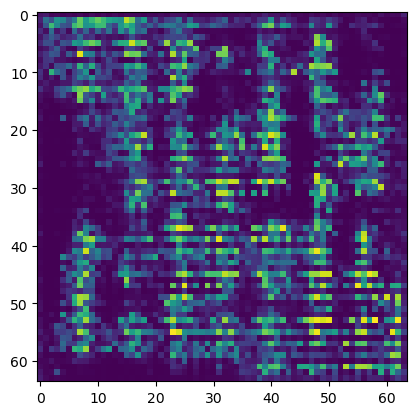

epoch = 141
Gen loss = tf.Tensor(0.047664966, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08124065, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 142
Gen loss = tf.Tensor(0.050362047, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0875808, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 143
Gen loss = tf.Tensor(0.052189186, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08337266, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 144
Gen loss = tf.Tensor(0.046626993, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08284089, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 145
Gen loss = tf.Tensor(0.04462834, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.086093135, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 146
Gen loss = tf.Tensor(0.047773566, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08440667, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 147
Gen loss = tf.Tensor(0.044772923, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.086433

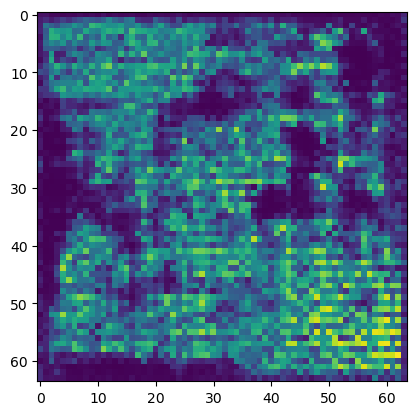

epoch = 151
Gen loss = tf.Tensor(0.04525528, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.088615775, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 152
Gen loss = tf.Tensor(0.04441473, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.088890046, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 153
Gen loss = tf.Tensor(0.044591278, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.087970935, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 154
Gen loss = tf.Tensor(0.04346659, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08766298, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 155
Gen loss = tf.Tensor(0.0432776, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08770719, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 156
Gen loss = tf.Tensor(0.045188427, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08762418, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 157
Gen loss = tf.Tensor(0.04545524, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08791850

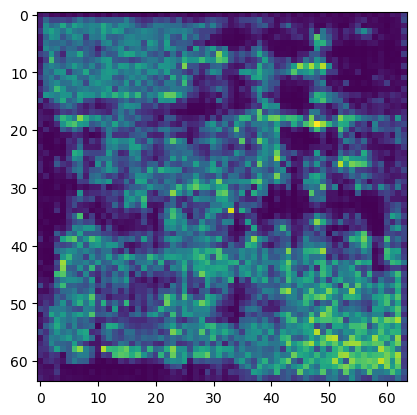

epoch = 161
Gen loss = tf.Tensor(0.045991484, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08579176, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 162
Gen loss = tf.Tensor(0.047098055, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08598793, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 163
Gen loss = tf.Tensor(0.04545869, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.086221315, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 164
Gen loss = tf.Tensor(0.045732155, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0858961, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 165
Gen loss = tf.Tensor(0.046942793, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.085703485, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 166
Gen loss = tf.Tensor(0.04643643, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08599053, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 167
Gen loss = tf.Tensor(0.04586128, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0851893

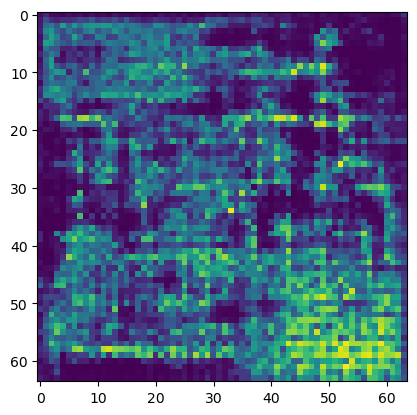

epoch = 171
Gen loss = tf.Tensor(0.04673849, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08532643, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 172
Gen loss = tf.Tensor(0.04802892, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.084740624, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 173
Gen loss = tf.Tensor(0.04696804, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08380399, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 174
Gen loss = tf.Tensor(0.047222722, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.084633715, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 175
Gen loss = tf.Tensor(0.048115544, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.084677495, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 176
Gen loss = tf.Tensor(0.0466054, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.084298804, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 177
Gen loss = tf.Tensor(0.048313603, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.084428

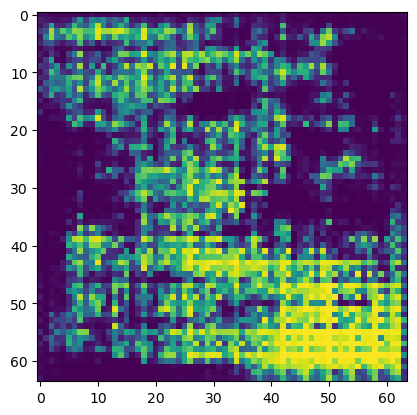

epoch = 181
Gen loss = tf.Tensor(0.055063598, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.079177335, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 182
Gen loss = tf.Tensor(0.054059334, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07804861, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 183
Gen loss = tf.Tensor(0.06390617, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07267767, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 184
Gen loss = tf.Tensor(0.05732897, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.070899725, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 185
Gen loss = tf.Tensor(0.06144975, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.075856455, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 186
Gen loss = tf.Tensor(0.05731142, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.077646956, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 187
Gen loss = tf.Tensor(0.080671854, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05567

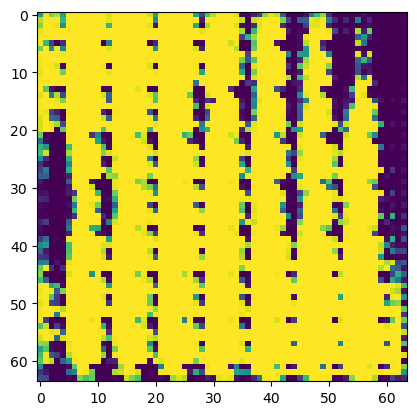

epoch = 191
Gen loss = tf.Tensor(0.06976557, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06298597, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 192
Gen loss = tf.Tensor(0.061818454, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.069846034, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 193
Gen loss = tf.Tensor(0.087356746, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04975633, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 194
Gen loss = tf.Tensor(0.07266758, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.053342957, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 195
Gen loss = tf.Tensor(0.06713767, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058204252, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 196
Gen loss = tf.Tensor(0.0639789, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06953656, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 197
Gen loss = tf.Tensor(0.08678496, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04732249

In [61]:

gen_losses, disc_losses, generated_map, disc_accuracies = train(training_data, N_EPOCHS)


Denormalize, save and display generated map output

(64, 64)


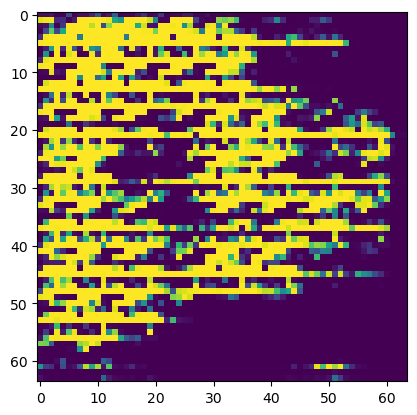

In [62]:
# denormalise generated map

generated_map *= 255

generated_map = generated_map.numpy()

generated_map = np.reshape(generated_map, (64,64))

generated_map = np.round(generated_map,0)
print(generated_map.shape)

#write generated map to csv


np.savetxt('generated_map.csv', generated_map, delimiter=',', fmt='%i')

generated_map = generated_map.tolist()


plt.imshow(generated_map)

# Graphs:

Losses

Text(0.5, 0, 'Epoch')

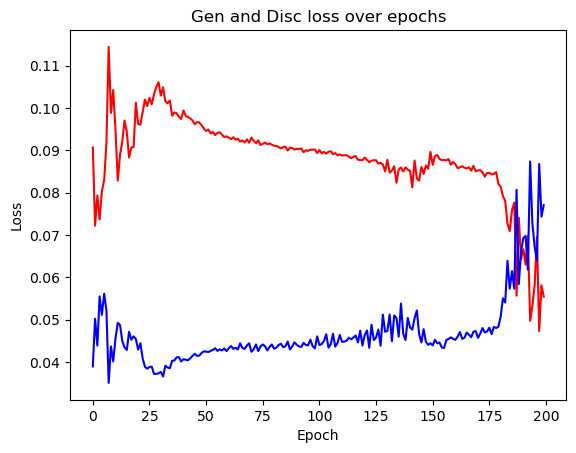

In [63]:
epoch_list = [i for i in range(0,N_EPOCHS)]


plt.plot(epoch_list, disc_losses,  'r-')
plt.plot(epoch_list, gen_losses, 'b-')
plt.title('Gen and Disc loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Discriminator Accuracy

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3600,) + inhomogeneous part.

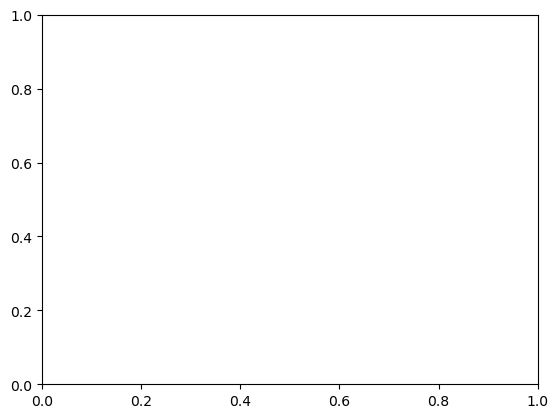

In [64]:
plt.plot(epoch_list, disc_accuracies,  'r-')

plt.title('Disc accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')